# Binary VAE para Hash
### Francisco Mena
Basado en:
* https://github.com/EderSantana/gumbel/
* https://github.com/EmilienDupont/vae-concrete
---

> ## Binary Variational Semantic Hashing

---

Load libraries to use

In [143]:
import numpy as np
import keras
from keras.layers import *
from keras.models import Sequential,Model
from keras import backend as K
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('reuters')
nltk.download('wordnet')

from base_networks import *

[nltk_data] Downloading package reuters to /home/fmena/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package wordnet to /home/fmena/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Load Data

In [2]:
#random data
X = np.random.rand(10000,5000)
X.shape

(10000, 5000)

### 20 Newsgroup
---

Citado por Semantic Hashing (http://people.csail.mit.edu/jrennie/20Newsgroups), también disponible en **sklearn**. El dataset contiene textos de noticias etiquetados como pertenenciente a uno de 20 grupos de noticias, el detalle de los conjuntos se detalla a continuación:

|Tipo set|Datos|
|---|---|
|Entrenamiento|11.314|
|Pruebas|7.532|



Hinton cita: *The data was split by date into 11,314 training and 7,531 test articles, so the training and test sets were separated in time.The training set was further randomly split into 8,314 training and 3,000 validation document*

In [45]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_t = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
labels = newsgroups_t.target_names

texts_t = newsgroups_t.data
y_t = newsgroups_t.target
labels_t = [labels[valor] for valor in y_t]

texts_test = newsgroups_test.data
y_test = newsgroups_test.target
labels_test = [labels[valor] for valor in y_test]

print("Datos de entrenamiento: ",y_train.shape)
print("Datos de prueba: ",y_test.shape)

Datos de entrenamiento:  (11314,)
Datos de prueba:  (7532,)


In [35]:
labels

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Anteriormente se presentan los 20 posibles grupos de las noticias, algunos ejemplos de texto se muestran a continuacion:

In [18]:
print(aux.data[0])

From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




### Reuters21578
---
Similar a 20NewsGroup es un datataset de textos de noticias del periodico de Reuters en 1987 , citado en papers (https://www.nltk.org/book/ch02.html) y disponible en la librería **nltk**. El detalle de los conjuntos se muestra a continuación:

|Tipo set|Datos|
|---|---|
|Entrenamiento|7.769|
|Pruebas|3.019|

Los documentos pueden pertenecer a **múltiples tópicos** dentro de 90 disponibles en el dataset manualmente etiquetadas, ésto es porque una noticia puede hablar de varios tópicos a la vez. 

In [46]:
from nltk.corpus import reuters
documents_stat = reuters.fileids()
print(str(len(documents_stat)) + " documents")

train_docs_stat = list(filter(lambda doc: doc.startswith("train"), documents_stat))
print(str(len(train_docs_stat)) + " total training documents")
test_docs_stat = list(filter(lambda doc: doc.startswith("test"), documents_stat))
print(str(len(test_docs_stat)) + " total test documents")

texts_t = [reuters.raw(archivo) for archivo in train_docs_stat]
labels_t = [reuters.categories(archivo) for archivo in train_docs_stat]

texts_test = [reuters.raw(archivo) for archivo in test_docs_stat]
labels_test = [reuters.categories(archivo) for archivo in test_docs_stat]

10788 documents
7769 total training documents
3019 total test documents


In [17]:
labels = reuters.categories()
labels

['acq',
 'alum',
 'barley',
 'bop',
 'carcass',
 'castor-oil',
 'cocoa',
 'coconut',
 'coconut-oil',
 'coffee',
 'copper',
 'copra-cake',
 'corn',
 'cotton',
 'cotton-oil',
 'cpi',
 'cpu',
 'crude',
 'dfl',
 'dlr',
 'dmk',
 'earn',
 'fuel',
 'gas',
 'gnp',
 'gold',
 'grain',
 'groundnut',
 'groundnut-oil',
 'heat',
 'hog',
 'housing',
 'income',
 'instal-debt',
 'interest',
 'ipi',
 'iron-steel',
 'jet',
 'jobs',
 'l-cattle',
 'lead',
 'lei',
 'lin-oil',
 'livestock',
 'lumber',
 'meal-feed',
 'money-fx',
 'money-supply',
 'naphtha',
 'nat-gas',
 'nickel',
 'nkr',
 'nzdlr',
 'oat',
 'oilseed',
 'orange',
 'palladium',
 'palm-oil',
 'palmkernel',
 'pet-chem',
 'platinum',
 'potato',
 'propane',
 'rand',
 'rape-oil',
 'rapeseed',
 'reserves',
 'retail',
 'rice',
 'rubber',
 'rye',
 'ship',
 'silver',
 'sorghum',
 'soy-meal',
 'soy-oil',
 'soybean',
 'strategic-metal',
 'sugar',
 'sun-meal',
 'sun-oil',
 'sunseed',
 'tea',
 'tin',
 'trade',
 'veg-oil',
 'wheat',
 'wpi',
 'yen',
 'zinc']

In [5]:
label2idx = {label:i for i,label in enumerate(labels)}
y_t = np.asarray([label2idx[label] for label in labels_t])
y_test = np.asarray([label2idx[label] for label in labels_test])
y_t

TypeError: unhashable type: 'list'

In [6]:
print(texts_train[0])

BAHIA COCOA REVIEW
  Showers continued throughout the week in
  the Bahia cocoa zone, alleviating the drought since early
  January and improving prospects for the coming temporao,
  although normal humidity levels have not been restored,
  Comissaria Smith said in its weekly review.
      The dry period means the temporao will be late this year.
      Arrivals for the week ended February 22 were 155,221 bags
  of 60 kilos making a cumulative total for the season of 5.93
  mln against 5.81 at the same stage last year. Again it seems
  that cocoa delivered earlier on consignment was included in the
  arrivals figures.
      Comissaria Smith said there is still some doubt as to how
  much old crop cocoa is still available as harvesting has
  practically come to an end. With total Bahia crop estimates
  around 6.4 mln bags and sales standing at almost 6.2 mln there
  are a few hundred thousand bags still in the hands of farmers,
  middlemen, exporters and processors.
      There are doubt

In [47]:
#borrar para presentacion
labels_t[:10]

[['cocoa'],
 ['acq'],
 ['money-supply'],
 ['acq'],
 ['earn'],
 ['earn'],
 ['acq', 'trade'],
 ['earn'],
 ['crude', 'nat-gas'],
 ['cocoa', 'coffee', 'sugar']]

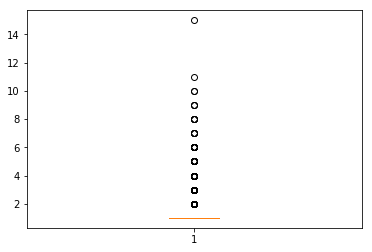

In [77]:
plt.boxplot(list(map(len,labels_t)))
plt.show()

### TMC
---
https://c3.nasa.gov/dashlink/resources/138/, 
https://catalog.data.gov/dataset/siam-2007-text-mining-competition-dataset

Revisar: https://github.com/Buzz-Beater/SIAM-2007-Text-Mining

### SearchSnipet
---
Dataset de Google search *snippets*-- pequeñas porciones de texto que le dan a usuarios una idea de lo que hay en el sitio web. Pertenecientes a 8 clases únicas (dominio).


2,280

http://jwebpro.sourceforge.net/data-web-snippets.tar.gz


### Reuters Corpus Volume 1
---
Corpus de Reuters extendido, con los 103 tópicos originales. Disponible en trabajos previos (https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multilabel.html) y a través de **sklearn**.


La representación son las *features* ya extraídas.

Probar este una vez ya experimentado con los pequeños anteriores


In [10]:
#https://scikit-learn.org/0.17/datasets/rcv1.html
from sklearn.datasets import fetch_rcv1
rcv1_train = fetch_rcv1(subset='train')
rcv1_test = fetch_rcv1(subset='test')
X_train = rcv1_train.data
y_train = rcv1_train.target
X_test = rcv1_test.data
y_test = rcv1_test.target

X_train

<23149x47236 sparse matrix of type '<class 'numpy.float64'>'
	with 1757801 stored elements in Compressed Sparse Row format>

In [11]:
X_train.shape

(23149, 47236)

In [13]:
y_test.shape

(781265, 103)

In [15]:
rcv1_train.target_names

array(['C11', 'C12', 'C13', 'C14', 'C15', 'C151', 'C1511', 'C152', 'C16',
       'C17', 'C171', 'C172', 'C173', 'C174', 'C18', 'C181', 'C182',
       'C183', 'C21', 'C22', 'C23', 'C24', 'C31', 'C311', 'C312', 'C313',
       'C32', 'C33', 'C331', 'C34', 'C41', 'C411', 'C42', 'CCAT', 'E11',
       'E12', 'E121', 'E13', 'E131', 'E132', 'E14', 'E141', 'E142',
       'E143', 'E21', 'E211', 'E212', 'E31', 'E311', 'E312', 'E313',
       'E41', 'E411', 'E51', 'E511', 'E512', 'E513', 'E61', 'E71', 'ECAT',
       'G15', 'G151', 'G152', 'G153', 'G154', 'G155', 'G156', 'G157',
       'G158', 'G159', 'GCAT', 'GCRIM', 'GDEF', 'GDIP', 'GDIS', 'GENT',
       'GENV', 'GFAS', 'GHEA', 'GJOB', 'GMIL', 'GOBIT', 'GODD', 'GPOL',
       'GPRO', 'GREL', 'GSCI', 'GSPO', 'GTOUR', 'GVIO', 'GVOTE', 'GWEA',
       'GWELF', 'M11', 'M12', 'M13', 'M131', 'M132', 'M14', 'M141',
       'M142', 'M143', 'MCAT'], dtype=object)

### Reuters Corpus Volume 2
---
The Reuter Corpus Volume 2 dataset is available at http://trec.nist.gov/data/reuters/reuters.html

or this dataset, we define the relevance of one document to
another to be the fraction of the topic labels that agree on the two
paths from the root to the two documents.


The data was randomly split into 402,207 training and 402,207
test articles. The training set was further randomly split into 302,207
training and 100,000 validation documents. 

In [ ]:
## no utilizar

### Validation creation

In [56]:
from sklearn.model_selection import train_test_split
texts_train,texts_val,labels_train,labels_test  = train_test_split(texts_t,labels_t,random_state=20,test_size=0.25)
print("Cantidad de datos Entrenamiento: ",len(texts_train))
print("Cantidad de datos Validación: ",len(texts_val))
print("Cantidad de datos Pruebas: ",len(texts_test))

Cantidad de datos Entrenamiento:  5826
Cantidad de datos Validación:  1943
Cantidad de datos Pruebas:  3019


## Pre-process
---
Obtain the data representation


paper Variational Deep Semantic Hashing:
> "*Each dataset was split into three subsets with roughly 80% for training, 10% for validation, and 10% for test. The training data is used to learn the mapping from document to hash code. Each document in the test set is used to retrieve similar documents based on the mapping, and the results are evaluated. The validation set is used to choose the hyperparameters. We removed the stopwords using SMART’s list of 571 stopwords 5 . No stemming was performed. We use TFIDF [23] as the default term weighting scheme for the raw document representation (i.e., d). We experiment with other term weighting schemes in Section 5.4.*"

REvisar si este paper hace algo con la cantidad de features

Hinton: 
> "*We further preprocessed the data by removing common stopwords, stemming, and then only considering the 2000 most frequent words in the training dataset. As a result, each posting was represented as a vector containing 2000 word counts. No other preprocessing was done.*"



* Stemmed version (citado en 2 trabajos) -> http://web.ist.utl.pt/acardoso/datasets/  


Se experimenta con dos tipos de pre-procesamiento:

1. El primero es el siguiente: 
    * Pasar letras a minúsculas
    * Eliminar extra espacios (saltos de línea por ejemplo)
    * Remover stop words
    * Borrar todo lo que no sea letras (eliminar números y puntuaciones)
    * Dejar palabras con una frecuencia mayor a ... o conservar las top $k$ palabras más frecuentes
2. El segundo añade lo siguiente:
    * Se realiza un *stemming* (Snowball)
    * Revisar el remover palabras de menos de 3 largo



Para la representación se utiliza lo siguiente:
* TF-IDF: 
$$ w_f(d) \cdot \left(1 + log\left( \frac{1+n_d}{1+df_w} \right) \right)$$
* **TF (*term frecuency*)**: $$ w_f(d) $$
* Binary: $$I(w_f(d) \neq 0)$$

In [159]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
analyzer = TfidfVectorizer().build_analyzer()
stemmer = SnowballStemmer("english") #maybe lemmatizer so can explain/interpretae

def number_normalize(doc):
    return ("#NUMBER" if token[0].isdigit() else token for token in analyzer(doc)) #probar el largo de palabras
def stemmed_words(doc):
    return (w for w in ("#NUMBER" if token[0].isdigit() else stemmer.stem(token) for token in analyzer(doc)) if len(w)>2 )

mode = "default"

#defaul is tf
smooth_idf_b = False
use_idf_b = False
binary_b = False
sublinear_tf_b = False

if mode == 'binary':
    binary_b = True
elif mode == 'tf':
    pass
elif mode == 'tf-idf':
    use_idf_b = True
    smooth_idf_b = True #inventa 1 conteo imaginario (como priors)--laplace smoothing
    #sublinear_tf_b = True #verificar: reemplaza tf por 1 + log(tf)
    
vectorizer = TfidfVectorizer(stop_words='english',analyzer=number_normalize,min_df=5,max_features=2000,lowercase=True 
                ,binary=binary_b, use_idf=use_idf_b, smooth_idf=smooth_idf_b,sublinear_tf=sublinear_tf_b,norm=False) 
vectorizer.fit(texts_train)

vectors_train = vectorizer.transform(texts_train)
vectors_val = vectorizer.transform(texts_val)
vectors_test = vectorizer.transform(texts_train)

vectors_train.shape

(5826, 2000)

vocabulario de 7mil en reuters,  10mil en newsgroup

In [160]:
#vocabulario???????
token2idx = vectorizer.vocabulary_
idx2token = {idx:token for token,idx in token2idx.items()}
idx2token

{0: '#NUMBER',
 1: 'ab',
 2: 'ability',
 3: 'able',
 4: 'about',
 5: 'above',
 6: 'abroad',
 7: 'accept',
 8: 'accepted',
 9: 'access',
 10: 'accord',
 11: 'according',
 12: 'account',
 13: 'accounted',
 14: 'accounting',
 15: 'accounts',
 16: 'achieve',
 17: 'acquire',
 18: 'acquired',
 19: 'acquires',
 20: 'acquisition',
 21: 'acquisitions',
 22: 'acreage',
 23: 'acres',
 24: 'across',
 25: 'act',
 26: 'action',
 27: 'actions',
 28: 'active',
 29: 'activities',
 30: 'activity',
 31: 'actual',
 32: 'add',
 33: 'added',
 34: 'adding',
 35: 'addition',
 36: 'additional',
 37: 'adjusted',
 38: 'adjustment',
 39: 'adjustments',
 40: 'administration',
 41: 'adopted',
 42: 'advanced',
 43: 'advances',
 44: 'advantage',
 45: 'aerospace',
 46: 'affairs',
 47: 'affect',
 48: 'affected',
 49: 'affiliate',
 50: 'africa',
 51: 'african',
 52: 'after',
 53: 'afternoon',
 54: 'ag',
 55: 'again',
 56: 'against',
 57: 'agency',
 58: 'ago',
 59: 'agree',
 60: 'agreed',
 61: 'agreement',
 62: 'agreemen

In [161]:
#todense --get representation
X_train = np.asarray(vectors_train.todense())
X_val = np.asarray(vectors_val.todense())
X_test = np.asarray(vectors_test.todense())
X_train[0]

array([6., 0., 0., ..., 0., 0., 0.])

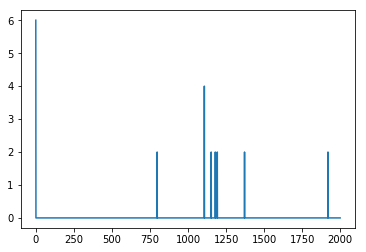

In [162]:
plt.plot(X_train[0])
plt.show()

In [ ]:
results = pd.DataFrame(matrix.toarray(), columns=vec.get_feature_names())
results

In [15]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

### Model Architecture
---
Basado en Variational Deep Semantic Hashing, una arquitectura de autoencoder no simétrico:

Input(|V|) -> Relu(500 o 1000) -> Relu (500 o 1000) -> Dropout() -> Laten variable(32) (8-128)*2 -> Sampling -> Softmax(|V|)

Hinton realiza lo mismo pero en modo espejo (simétrico).

* Tensorflow: https://github.com/unsuthee/VariationalDeepSemanticHashing/blob/master/VDSH.py
* PyTorch: https://github.com/unsuthee/SemanticHashingWeakSupervision

In [35]:
def traditional_VAE(data_dim,Nb,units,layers_e,layers_d,opt='adam'):
    pre_encoder = define_pre_encoder(data_dim, layers=layers_e,units=units)
    print("pre-encoder network:")
    pre_encoder.summary()
    
    generator = define_generator(Nb,data_dim,layers=layers_d,units=units)
    print("generator network:")
    generator.summary()
    
    ## Encoder
    x = Input(shape=(data_dim,))
    hidden = pre_encoder(x)
    z_mean = Dense(Nb,activation='linear', name='z-mean')(hidden)
    z_log_sigma = Dense(Nb,activation='linear',name = 'z-log_sigma')(hidden)
    encoder = Model(x, z_mean) # build a model to project inputs on the latent space

    def sampling(args):
        epsilon_std = 1.0
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], Nb),mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_sigma) * epsilon #+sigma (desvest)
    
    ## Decoder
    z_sampled = Lambda(sampling, output_shape=(Nb,), name='sampled')([z_mean, z_log_sigma])
    output = generator(z_sampled)

    def vae_loss(x, x_hat):
        reconstruction_loss = keras.losses.categorical_crossentropy(x, x_hat)*data_dim 
        #reconstruction_loss = keras.losses.binary_crossentropy(x, x_hat)*data_dim 

        kl_loss = - 0.5 * K.sum(1 + 2*z_log_sigma - K.square(z_mean) - K.square(K.exp(z_log_sigma)), axis=-1) #con varianza
        return K.mean(reconstruction_loss  + kl_loss) #ya que kl es suma K.mean()

    traditional_vae = Model(x, output)
    traditional_vae.compile(optimizer=opt,loss=vae_loss)
    return traditional_vae

traditional_vae = traditional_VAE(5000,512,16)
traditional_vae.summary()

TypeError: traditional_VAE() missing 2 required positional arguments: 'layers_e' and 'layers_d'

### Train details
---

Deep Semantic Variational Hashing:
* Glorot initializer (Weights)
* Adam Optimizer (step size 0.001)
* Dropout (80%)-- overfitting
* 25-30 epochs
* batch size = 1 o 100

Semantic Hashing:
* Manual initializer (Weights) -- similar to as glorot
* Optimizer SGD (lr = 0.1, momentum 0.9, weight decay 0.0002)
* 50 epochs
* batch size de 100

In [39]:
batch_size = 100
epochs = 100
traditional_vae = traditional_VAE(x_train.shape[1],Nb=32,units=256,layers_e=1,layers_d=1)
#also compile here...
traditional_vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size)

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 256)               200960    
Total params: 200,960
Trainable params: 200,960
Non-trainable params: 0
_________________________________________________________________
1
generator network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 256)               8448      
_________________________________________________________________
dense_70 (Dense)             (None, 784)               201488    
Total params: 209,936
Trainable params: 209,936
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
60000/60000 [==============================] - 6s 92us/step - loss: 424556.0888
Epoch 2/100
60000/60000 [==============================] - 4s 

KeyboardInterrupt: 

In [59]:
data_dim = x_train.shape[1]
layers_e = 1
layers_d = 1
units = 256
Nb = 32 #Number of bits
opt= 'adam'

#def traditional_VAE(data_dim,Nb,units,layers_e,layers_d,opt='adam'):
pre_encoder = define_pre_encoder(data_dim, layers=layers_e,units=units)
print("pre-encoder network:")
pre_encoder.summary()

generator = define_generator(Nb,data_dim,layers=layers_d,units=units)
print("generator network:")
generator.summary()
    

tau = K.variable(5.0, name="temperature") #hay que setearlo..

x = Input(shape=(data_dim,))
hidden = pre_encoder(x)
logits_b  = Dense(Nb, activation='linear', name='logits-b')(hidden) #log(p(b)/1-p(b))
#proba = np.exp(logits_b)/(1+np.exp(logits_b)) = sigmoidal(logits_b) <<<<<<<<<< recuepra probabilidad

#dist = Dense(Nb, activation='sigmoid')(hidden) #p(b)

encoder = Model(x, logits_b)

def sample_gumbel(shape,eps=K.epsilon()):
    """Inverse Sample function from Gumbel(0, 1)"""
    U = K.random_uniform(shape, 0, 1)
    return K.log(U + eps)- K.log(1-U + eps)
        
def sampling(aux):
    #logits_b = K.log(aux/(1-aux) + K.epsilon() )
    logits_b = aux
    b = logits_b + sample_gumbel(K.shape(logits_b)) # logits + gumbel noise
    return keras.activations.sigmoid( b/tau )

b_sampled = Lambda(sampling, output_shape=(Nb,), name='sampled')(logits_b)
output = generator(b_sampled)

#Me tinca que está mal:
def gumbel_loss(x, x_hat):
    reconstruction_loss = keras.losses.categorical_crossentropy(x, x_hat)*data_dim
    
    dist = keras.activations.sigmoid(logits_b) #q(b)
        
    kl_disc_loss = Nb*np.log(2) + K.sum( dist*K.log(dist + K.epsilon()) + (1-dist)* K.log(1-dist + K.epsilon()),axis=1)
    return reconstruction_loss  + kl_disc_loss

binary_vae = Model(x, output)
binary_vae.compile(optimizer=opt, loss=gumbel_loss)
binary_vae.summary()

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_102 (Dense)            (None, 256)               200960    
Total params: 200,960
Trainable params: 200,960
Non-trainable params: 0
_________________________________________________________________
1
generator network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 256)               8448      
_________________________________________________________________
dense_104 (Dense)            (None, 784)               201488    
Total params: 209,936
Trainable params: 209,936
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_81 (InputLayer) 

In [60]:
binary_vae.fit(x_train,x_train,epochs=20)

Epoch 1/20
60000/60000 [==============================] - 14s 241us/step - loss: 430133.7091
Epoch 2/20
60000/60000 [==============================] - 13s 211us/step - loss: 415458.1029
Epoch 3/20
60000/60000 [==============================] - 13s 211us/step - loss: 412067.7339
Epoch 4/20
60000/60000 [==============================] - 13s 211us/step - loss: 410127.5774
Epoch 5/20
60000/60000 [==============================] - 13s 212us/step - loss: 408833.8265
Epoch 6/20
60000/60000 [==============================] - 13s 211us/step - loss: 407926.5176
Epoch 7/20
60000/60000 [==============================] - 13s 212us/step - loss: 407283.1832
Epoch 8/20
60000/60000 [==============================] - 13s 210us/step - loss: 406779.0565
Epoch 9/20
51360/60000 [========================>.....] - ETA: 1s - loss: 406596.8077

KeyboardInterrupt: 

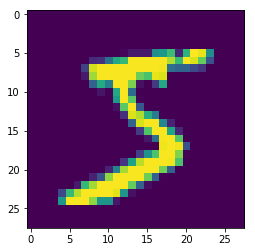

In [56]:
plt.imshow(x_train[0].reshape(28,28))

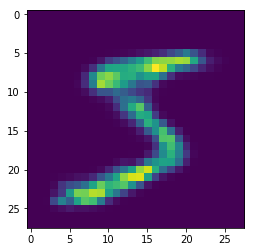

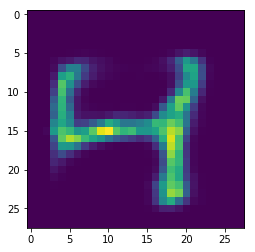

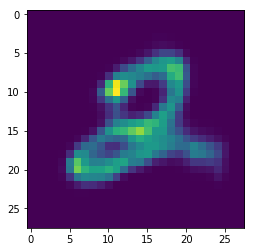

In [61]:
predict_x = binary_vae.predict(x_train)
plt.imshow(predict_x[0].reshape(28,28))
plt.show()
plt.imshow(predict_x[2].reshape(28,28))
plt.show()
plt.imshow(predict_x[5].reshape(28,28))

In [100]:
U = K.random_uniform((8,), 0, 1)
U.eval(session=K.get_session())

array([0.9292773 , 0.65858245, 0.91319764, 0.16799355, 0.14256966,
       0.25475013, 0.01682949, 0.86192214], dtype=float32)

In [31]:
#obtener probabilidades de codigos binarios
logits = encoder.predict(X[:1000])
probas = keras.activations.sigmoid(logits).eval(session=K.get_session())
probas

array([[0.43783456, 0.29870096, 0.6656069 , ..., 0.6301294 , 0.77129394,
        0.18610832],
       [0.37131384, 0.31683958, 0.55881345, ..., 0.7582314 , 0.7540688 ,
        0.2598843 ],
       [0.33411175, 0.40805054, 0.44053924, ..., 0.65402764, 0.7095646 ,
        0.18874496],
       ...,
       [0.37332126, 0.33784363, 0.6420201 , ..., 0.76295245, 0.7818115 ,
        0.19926082],
       [0.35585272, 0.41265407, 0.5599596 , ..., 0.62157196, 0.7591367 ,
        0.17027016],
       [0.468956  , 0.3313979 , 0.5188709 , ..., 0.68151903, 0.6636331 ,
        0.13369915]], dtype=float32)

In [94]:
#generar la distribucion de probabildiad dado un codigo binario
#dada una probabilidad sobre el codigo
proba_b = np.random.rand(2,Nb)
b = sampling(proba_b).eval(session=K.get_session())

#dado un codigo binario
#b = np.ones((2,Nb))

reconstruct_data = generator.predict(b)
reconstruct_data

array([[0.0001948 , 0.00020341, 0.00020224, ..., 0.00019884, 0.00019546,
        0.00020585],
       [0.00019493, 0.00020488, 0.0002041 , ..., 0.00019809, 0.00019341,
        0.00020736]], dtype=float32)

In [41]:
batch_size = 100
epochs = 100
binary_vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size)

Epoch 1/100
60000/60000 [==============================] - 6s 93us/step - loss: nan
Epoch 2/100
20500/60000 [=========>....................] - ETA: 2s - loss: nan

KeyboardInterrupt: 

### Results
---
Resultados y comparar

In [ ]:
precision
recall


### Analysis
---
Intepretar los códigos binarios en cada dataset